# Assignment 1


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
np.random.seed(13) #TODO Check if this is used for sgd
from itertools import combinations
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Reshape, Lambda
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from gensim.models import KeyedVectors
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as nn
from IPython.display import SVG, display
from keras.utils.vis_utils import model_to_dot
import gensim
from __future__ import division
from collections import OrderedDict

C:\Users\XE89IW.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\XE89IW.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# DO NOT Modify the lines in this cell
path = 'alice.txt'
corpus = open(path).readlines()[0:700]

corpus = [sentence for sentence in corpus if sentence.count(" ") >= 2]

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"'")
tokenizer.fit_on_texts(corpus)
corpus = tokenizer.texts_to_sequences(corpus)
nb_samples = sum(len(s) for s in corpus)
V = len(tokenizer.word_index) + 1
print('Vocabulary size:', V)

# Is this something they need to change?
dim = 100
dims = (50, 150, 300)
window_size = 2 #use this window size for Skipgram, CBOW, and the model with the additional hidden layer
window_size_corpus = 4 #use this window size for the co-occurrence matrix
inv_word_index = dict({v: k for k, v in tokenizer.word_index.items()})

Vocabulary size: 1183


## Question 1

### Co-occurrence Matrix
Use the provided code to load the "Alice in Wonderland" text document. 
1. Implement the word-word co-occurrence matrix for “Alice in Wonderland”
2. Normalize the words such that every value lies within a range of 0 and 1
3. Compute the cosine distance between the given words:
    - Alice 
    - Dinah
    - Rabbit
4. List the 5 closest words to 'Alice'. Discuss the results.
5. Discuss what the main drawbacks are of a term-term co-occurence matrix solutions?


In [79]:
def get_contexts(V, corpus, window_size):
    """For each word in the corpus, get the context words within given window size"""
    window_size *= 2
    for words in corpus:
        n_words = len(words)
        for i, w in enumerate(words):
            # find context words
            start, end = max(0, i - window_size), min(i + window_size + 1, n_words)
            context = [words[j] for j in range(start, i) if words[j] != words[i]]  # add co-occuring words before word
            context += [words[j] for j in range(i+1, end) if words[j] != words[i]]  # add co-occuring words after word
            yield w, context

def create_coocurrence_matrix(V, corpus, window_size):
    """create co-occurrence matrix"""
    matrix = np.zeros((V, V))
    for word, context in get_contexts(V, corpus, window_size):
        # update co-occurence matrix
#         matrix[word][word] += 1
        for c in context:
            matrix[word][c] += 1
    return matrix

print("Non-normalized:")
matrix = create_coocurrence_matrix(V, corpus, window_size_corpus)
print(matrix[1:, 1:])

# Normalize the matrix
print("Normalized by cosine similarity:")
matrix = cosine_similarity(matrix)
np.fill_diagonal(matrix, 0)
print(matrix[1:, 1:])

Non-normalized:
[[  0. 111.  98. ...   1.   1.   0.]
 [111.   0.  71. ...   1.   2.   1.]
 [ 98.  71.   0. ...   0.   0.   0.]
 ...
 [  1.   1.   0. ...   0.   1.   0.]
 [  1.   2.   0. ...   1.   0.   1.]
 [  0.   1.   0. ...   0.   1.   0.]]
Normalized by cosine similarity:
[[0.         0.72693084 0.75035998 ... 0.46272753 0.42138481 0.26685441]
 [0.72693084 0.         0.83422942 ... 0.58253263 0.43599029 0.1588899 ]
 [0.75035998 0.83422942 0.         ... 0.62068758 0.53321779 0.22791489]
 ...
 [0.46272753 0.58253263 0.62068758 ... 0.         0.69026849 0.4472136 ]
 [0.42138481 0.43599029 0.53321779 ... 0.69026849 0.         0.68599434]
 [0.26685441 0.1588899  0.22791489 ... 0.4472136  0.68599434 0.        ]]


In [73]:
bag_of_words = ['Alice', 'Dinah', 'Rabbit']
pair_of_words = list(combinations(bag_of_words, 2))
for pair in pair_of_words:
    idx = tuple(tokenizer.texts_to_sequences([" ".join(pair)])[0])
    print("Cosine similarity between {} and {}: {}".format(*pair, matrix[idx]))

Cosine similarity between Alice and Dinah: 0.5856941162939969
Cosine similarity between Alice and Rabbit: 0.6308201245059947
Cosine similarity between Dinah and Rabbit: 0.38920668461370095


In [81]:
#find the closest words to Alice
alice_idx = tokenizer.texts_to_sequences(["Alice"])[0][0]
closest5 = matrix[alice_idx].argsort()[-5:][::-1]
print([(inv_word_index[idx], matrix[alice_idx, idx]) for i, idx in enumerate(closest5)])

[('she', 0.8740011096211096), ('it', 0.8489720803420685), ('in', 0.8362329990682509), ('that', 0.8260777989010701), ('her', 0.8242080034809633)]


Discussion of the drawbacks:

- They take a long time to generate. We need to look at each word in the document 5 times (except words at the start and end of the sentences). For this reason it is useful to generate the matrix once and store it instead of building it each time.
- They use much memory. A |V x V| matrix is requred to store the co-occurence matrix. This can be done more efficient if the matrix is sparse.
- A co-occurence matrix is specific to the context on which it was build. The distances between words in the co-occurence matrix do not generalize to other contexts. 
- We need to define a window size before generating the matrix. The distances between words could differ with different window sizes. Testing this requires us to rebuild the word co-occurence matrix.

In [82]:
#Save your all the vector representations of your word embeddings in this way
#Change when necessary the sizes of the vocabulary/embedding dimension
def save_embeddings(file_name, vectors, V, dim):
    #vectors = your word co-occurrence matrix
    f = open(file_name, "w")
    f.write("{} {}\n".format(V, dim))
    for word, i in tokenizer.word_index.items():    
        f.write("{} {}\n".format(word, " ".join(map(str, list(vectors[i,:])))))
    f.close()

In [83]:
#save co-occurence matrix
save_embeddings('vectors_co_occurence.txt', matrix[:, 1:], V-1, V-1)

#reopen your file as follows
co_occurrence = KeyedVectors.load_word2vec_format('./vectors_co_occurrence.txt', binary=False)

## Question 2

### Word embeddings
Build embeddings with a keras implementation where the embedding vector is of length 50, 150 and 300. Use the Alice in Wonderland text book for training.
1. Using the CBOW model
2. Using Skipgram model
3. Add extra hidden dense layer to CBow and Skipgram implementations. Choose an activation function for that layer and justify your answer.
4. Analyze the four different word embeddings
    - Implement your own function to perform the analogy task with. Do not use existing libraries for this task such as Gensim. Your function should be able to answer whether an anaology as in the example given in the pdf-file is true.
    - Compare the performance on the analogy task between the word embeddings that you have trained in 2.1, 2.2 and 2.3.  
    - Visualize your results and interpret your results
5. Use the word co-occurence matrix from Question 1. Compare the performance on the analogy task with the performance of your trained word embeddings.  
6. Discuss:
    - What are the main advantages of CBOW and Skipgram?
    - What is the advantage of negative sampling?
    - What are the main drawbacks of CBOW and Skipgram?
7. Load pre-trained embeddings on large corpuses (see the pdf file). You only have to consider the word embeddings with an embedding size of 300
    - Compare performance on the analogy task with your own trained embeddings from "Alice in Wonderland". You can limit yourself to the vocabulary of Alice in Wonderland. Visualize the pre-trained word embeddings and compare these with the results of your own trained word embeddings. 


### CBoW

In [11]:
#prepare data for cbow
def generate_data_cbow(V, corpus, window_size):
    for word, context in get_contexts(V, corpus, window_size):
        x = sequence.pad_sequences([context], maxlen=window_size*2)
        y = np_utils.to_categorical([word], num_classes=V)
        yield x, y

#save the data of CBOW
f = open('data_cbow.txt', 'w')
for x, y in generate_data_cbow(V, corpus, window_size):
    f.write(" ".join(map(str, list(x[0]))))
    f.write(", ")
    f.write(" ".join(map(str, list(y[0]))))
    f.write("\n")
f.close()

#load the preprocessed CBOW data
def generate_data_cbow_from_file():
    f = open('data_cbow.txt', 'r')
    for row in f:
        x, y = row.split(",")
        x = np.fromstring(x, dtype=int, sep=' ')
        x = x.reshape(1, x.shape[0])
        y = np.fromstring(y, dtype=float, sep=' ')
        y = y.reshape(1, y.shape[0])
        yield x, y
    f.close()

Embedding vector length: 50


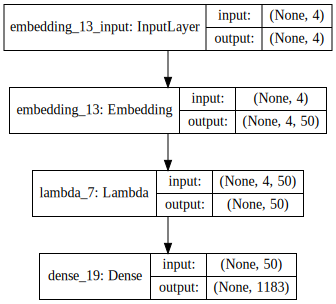

0 41542.9243581295
1 38920.20447087288
2 38902.04039347172
3 38709.12694942951
4 38381.06652420759
5 38050.04512602091
6 37800.23936293088
7 37721.407976307906
8 37850.254050738644
9 38144.16832207306
Embedding vector length: 150


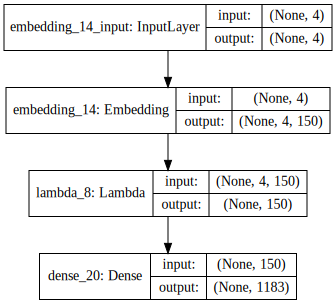

0 41374.828798651695
1 38475.8191832304
2 38208.28163844347
3 37765.569845318794
4 37193.54229557142
5 36597.97684511263
6 36043.613112815074
7 35550.87012729299
8 35120.09101299636
9 34758.907309637056
Embedding vector length: 300


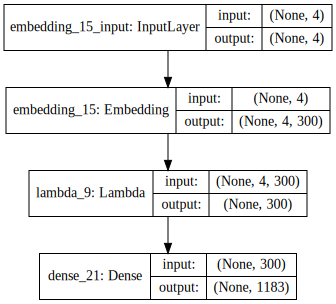

0 41244.75024652481
1 38093.83337563276
2 37621.715394079685
3 37023.79370869696
4 36307.672158856876
5 35589.24107949715
6 34918.877276319545
7 34314.57958056498
8 33775.90521171159
9 33290.705551066785


In [106]:
for dim in dims:
    print("Embedding vector length: {}".format(dim))
    
    #create CBOW model
    model = Sequential()
    model.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
    model.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(dim,)))
    model.add(Dense(V, activation='softmax'))

    #define loss function
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    model_vis = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    display(model_vis)

    #train model
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_cbow_from_file():
            loss += model.train_on_batch(x, y)
        print(ite, loss)
    
    #save embeddings to file
    save_embeddings('vectors_cbow_{}.txt'.format(dim), model.get_weights()[0], V-1, dim)

### Skipgram

In [7]:
#prepare data for Skipgram
def generate_data_skipgram(V, corpus, window_size):
    for word, context in get_contexts(V, corpus, window_size):
        n_context = len(context)
        if n_context == 0:
            continue
        x = np.array([word]*n_context).reshape(n_context, 1)
        y = np.concatenate([np_utils.to_categorical([c], num_classes=V) for c in context])
        yield x, y

#save the data of Skipgram
f = open('data_skipgram.txt', 'w')
for x, y in generate_data_skipgram(V, corpus, window_size):
    f.write(" ".join(map(str, list(x.flatten()))))
    f.write(", ")
    f.write(" ".join(map(str, list(y.flatten()))))
    f.write("\n")
f.close()

#load the preprocessed Skipgram data
def generate_data_skipgram_from_file():
    f = open('data_skipgram.txt', 'r')
    for row in f:
        x, y = row.split(",")
        x = np.fromstring(x, dtype=int, sep=' ')
        x = np.asarray(np.split(x, len(x)))
        y = np.fromstring(y, dtype=float, sep=' ')
        y = np.asarray(np.split(y, len(x)))
        yield x, y

Embedding vector length: 50


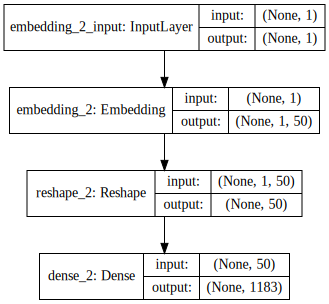

0 41058.361872434616
1 39137.43390774727
2 39254.84288263321
3 39330.85774564743
4 39411.00026965141
5 39498.04630613327
6 39593.00877952576
7 39695.283418655396
8 39801.34129524231
9 39906.14849483967
Embedding vector length: 150


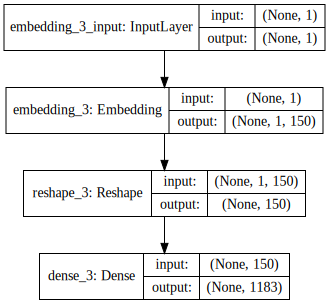

0 40997.32577085495
1 39027.46110320091
2 39075.00781226158
3 39090.905448913574
4 39119.07618975639
5 39161.269319176674
6 39206.97477567196
7 39244.4005613327
8 39268.97369801998
9 39282.16592299938
Embedding vector length: 300


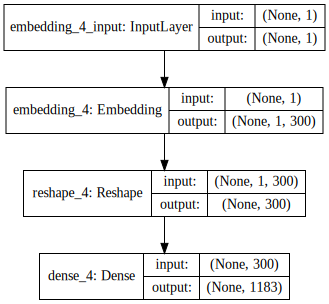

0 40921.37661242485
1 38913.360414266586
2 38887.228564977646
3 38844.15628814697
4 38821.88488280773
5 38802.58071088791
6 38770.443096995354
7 38725.42907047272
8 38678.670103907585
9 38619.635098695755


In [8]:
for dim in dims:
    print("Embedding vector length: {}".format(dim))
    
    #create Skipgram model
    model = Sequential()
    model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
    model.add(Reshape((dim, )))
    model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
    
    #define loss function for Skipgram
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    model_vis = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    display(model_vis)
    
    #train Skipgram model
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_skipgram_from_file():
            loss += model.train_on_batch(x, y)
        print(ite, loss)
    
    #save embeddings to file
    save_embeddings('vectors_skipgram_{}.txt'.format(dim), model.get_weights()[0], V-1, dim)

### CBoW + hidden dense layer

We add an additional hidden dense layer $D$. The number of units in $D$ is the same as the embeddings vector length and we use linear activation. We do not use any non-linear activation to keep the model simple. We compared the loss of each model as a function of the activation used. The linear activation produced the least loss for both the CBOW and the Skipgram models versus Sigmoid, tanh and ReLu. For brevity, we only show the results of linear activation.

Embedding vector length: 50


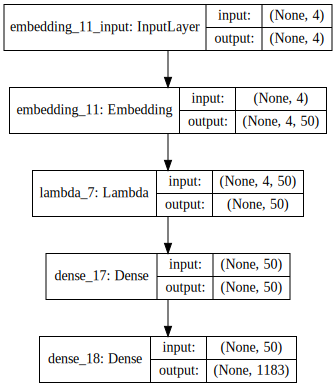

0 39941.94973671436
1 38480.14661645889
2 37670.89860379696
3 37937.573603235185
4 38408.41812585667
5 37626.238125349395
6 37127.10393234249
7 36462.35399510525
8 35755.37573868921
9 35231.93771386403
Embedding vector length: 150


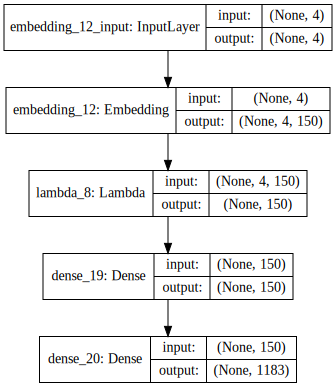

0 39507.02383184433
1 37377.39189885557
2 35971.437337853014
3 35410.582459898666
4 35041.253549247514
5 33833.8487204304
6 32782.37171193957
7 31905.352393839392
8 31141.18920276058
9 30510.85199861927
Embedding vector length: 300


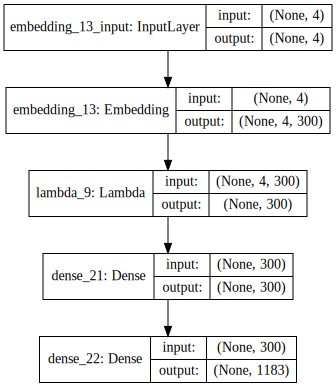

0 39336.15394940972
1 36337.156904414296
2 34419.44998855516
3 33786.9387864396
4 32547.53754113987
5 31244.23208662076
6 30083.749653739622
7 29190.68146104249
8 28576.38568912109
9 28051.789110360143


In [15]:
for dim in dims:
    print("Embedding vector length: {}".format(dim))
    
    #create CBOW model with additional dense layer
    model = Sequential()
    model.add(Embedding(input_dim=V, output_dim=dim, input_length=window_size*2))
    model.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(dim,)))
    model.add(Dense(dim, activation='linear'))  # additional dense layer
    model.add(Dense(V, activation='softmax'))
    
    #define loss function for CBOW
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    model_vis = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    display(model_vis)
    
    #train CBOW model
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_cbow_from_file():
            loss += model.train_on_batch(x, y)
        print(ite, loss)
    
    #save embeddings to file
    save_embeddings('vectors_cbow_dense_{}.txt'.format(dim), model.get_weights()[0], V-1, dim)

### Skipgram + hidden dense layer

Embedding vector length: 50


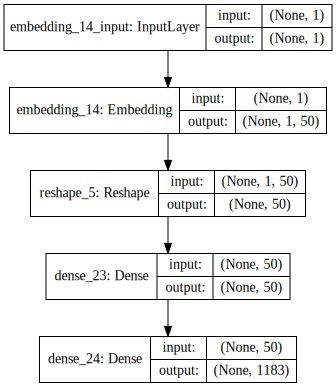

0 38905.603808403015
1 38437.43089199066
2 38426.69593858719
3 38351.8184940815
4 38298.276644706726
5 38256.745240688324
6 38199.839379787445
7 38156.221430420876
8 38074.80839276314
9 37993.15100598335
Embedding vector length: 150


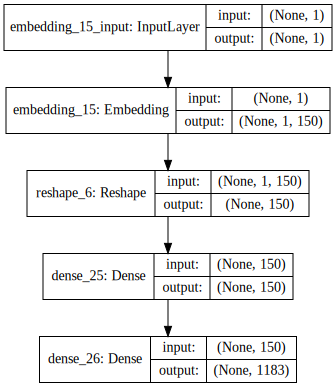

0 38535.28564739227
1 37891.14954948425
2 37723.83500123024
3 37583.222695827484
4 37412.15771484375
5 37243.26659679413
6 37043.81470298767
7 36758.534304857254
8 36351.15926027298
9 35983.04415130615
Embedding vector length: 300


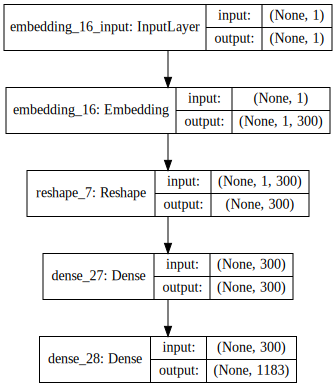

0 38066.5025510788
1 37367.42314195633
2 37111.51680254936
3 37033.06994354725
4 36909.993754029274
5 36679.54602217674
6 36455.70242750645
7 36194.68099629879
8 35940.86699569225
9 35695.40010714531


In [16]:
for dim in dims:
    print("Embedding vector length: {}".format(dim))
    
    #create Skipgram model with additional dense layer
    model = Sequential()
    model.add(Embedding(input_dim=V, output_dim=dim, embeddings_initializer='glorot_uniform', input_length=1))
    model.add(Reshape((dim, )))
    model.add(Dense(dim, activation='linear'))  # additional dense layer
    model.add(Dense(input_dim=dim, units=V, kernel_initializer='uniform', activation='softmax'))
    
    #define loss function for Skipgram
    model.compile(loss='categorical_crossentropy', optimizer='adadelta')
    model_vis = SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
    display(model_vis)
    
    #train Skipgram model
    for ite in range(10):
        loss = 0.
        for x, y in generate_data_skipgram_from_file():
            loss += model.train_on_batch(x, y)
        print(ite, loss)
    
    #save embeddings to file
    save_embeddings('vectors_skipgram_dense_{}.txt'.format(dim), model.get_weights()[0], V-1, dim)

### Analogy function

Note: We discarded analogy examples from the analogy_alice.txt which included words that were not present in the corpus. Therefore, we use only 38 of the 47 given examples.

Note: We created a weak analogy checking function, i.e., reduced the strictness of condition for checking analogies. For e.g., consider analogy "usual usually sudden suddenly". To check if this analogy is learned, we compute $lhs = v_{usual} - v_{usually} + v_{suddenly}$ and then we get the top 10 words $W_{10}$ in our vocabulary in terms of cosine similary to vector $lhs$. If word $sudden \in W_{10}$, then analogy is learned, otherwise not.

In [5]:
#Implement your own analogy function
def check_analogy(words, keyed_vec):
    """Find the top 10 most similar words to the analogy vector.
    If the analogous word is present in the top 10 most similar words, then return true
    otherwise, false. Gensim is only used to get the cosine similarity by vector."""
    lhs = keyed_vec.get_vector(words[0]) - keyed_vec.get_vector(words[1]) + keyed_vec.get_vector(words[3])
    closest10 = [w for w, sim in keyed_vec.similar_by_vector(lhs, topn=10)]
    return words[2] in closest10

def generate_data_analogy_from_file():
    f = open('analogy_alice.txt', 'r').readlines()
    f = [sentence.split() for sentence in f]
#     f = tokenizer.texts_to_sequences(f)
    for row in f:
        if len(row) == 4:
            yield row

def load_embeddings(file_name):
    f = open(file_name, 'r')
    V, dim = map(int, f.readline().split(' '))
    out = np.zeros((V + 1, dim))
    for row in f:
        row = row.split(' ')
        x = tokenizer.word_index[row[0]]
        y = list(map(float, row[1:]))
        out[x, :] = y
    return out

Comparison performance:

In [11]:
total_analogies = len(list(generate_data_analogy_from_file()))
analogy_words = [inv_word_index[w] for sentence in generate_data_analogy_from_file() for w in sentence]
models = ['cbow', 'skipgram', 'cbow_dense', 'skipgram_dense']
embeddings_files = ['vectors_{}_{}'.format(m, dim) for m in models for dim in dims]

KeyError: 'happy'

In [137]:
#compare performance
for f in embeddings_files:
    print('File:', f)
    model = KeyedVectors.load_word2vec_format(f + '.txt', binary=False)
    n_analogies_correct = 0
    for sentence in generate_data_analogy_from_file():
        if not all(w in model.vocab for w in sentence):
            continue
        analogy_task = check_analogy(sentence, model)
        n_analogies_correct += int(analogy_task)
    print('# of analogies correct:', n_analogies_correct)
    print('% of analogies correct: {:.2f}%\n'.format(n_analogies_correct / total_analogies * 100))

File: vectors_cbow_50
# of analogies correct: 1
% of analogies correct: 2.63%

File: vectors_cbow_150
# of analogies correct: 1
% of analogies correct: 2.63%

File: vectors_cbow_300
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_skipgram_50
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_skipgram_150
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_skipgram_300
# of analogies correct: 1
% of analogies correct: 2.63%

File: vectors_cbow_dense_50
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_cbow_dense_150
# of analogies correct: 2
% of analogies correct: 5.26%

File: vectors_cbow_dense_300
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_skipgram_dense_50
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_skipgram_dense_150
# of analogies correct: 0
% of analogies correct: 0.00%

File: vectors_skipgram_dense_300
# of analogies correct: 2
% of analogies 

Visualization: 
- We first compute the t-SNE projection of the embeddings in 2D.
- Then plot only the projection of the words used in the analogy task for clarity.

File: vectors_cbow_50


C:\Users\XE89IW.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


File: vectors_cbow_150
File: vectors_cbow_300
File: vectors_skipgram_50
File: vectors_skipgram_150
File: vectors_skipgram_300
File: vectors_cbow_dense_50
File: vectors_cbow_dense_150
File: vectors_cbow_dense_300
File: vectors_skipgram_dense_50
File: vectors_skipgram_dense_150
File: vectors_skipgram_dense_300


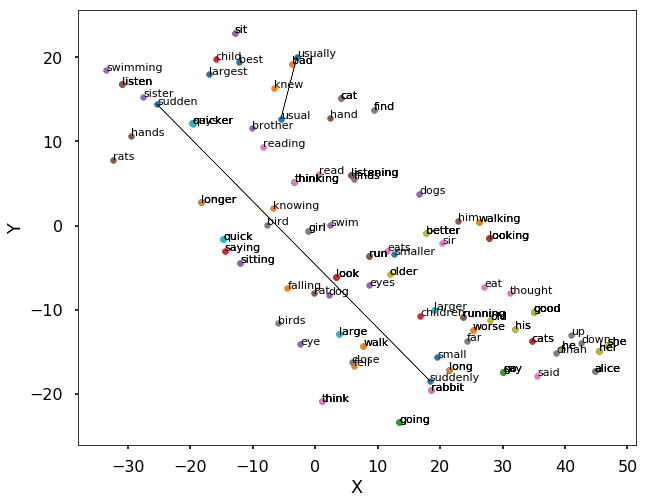

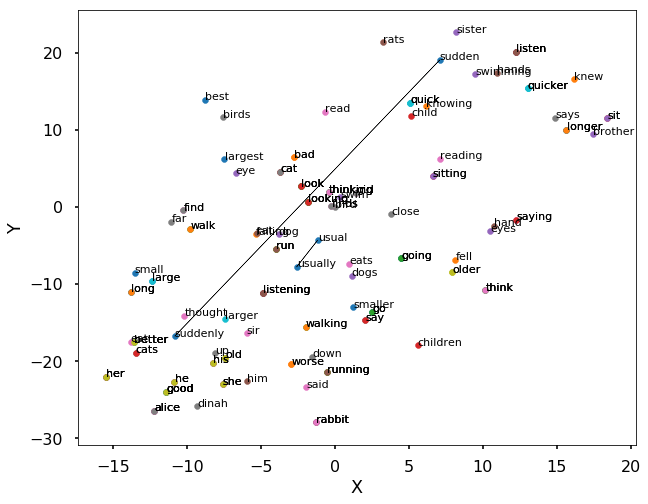

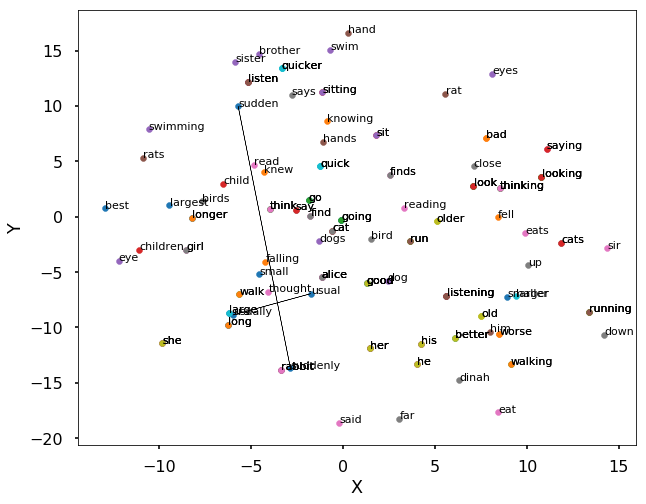

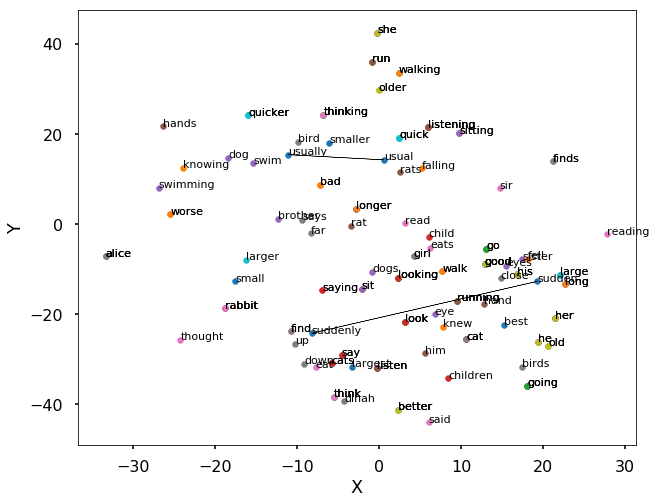

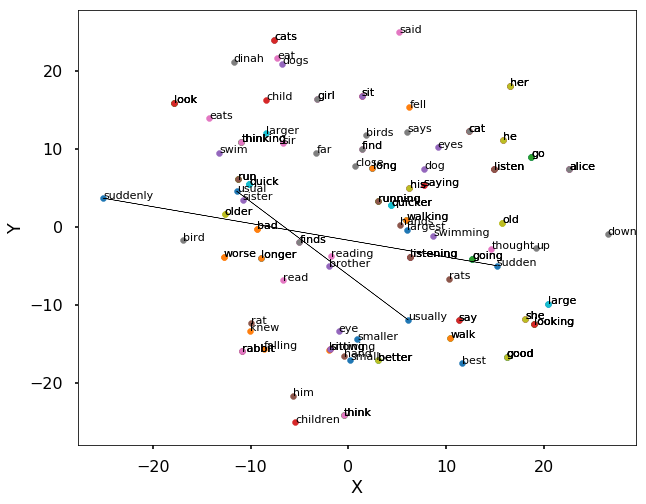

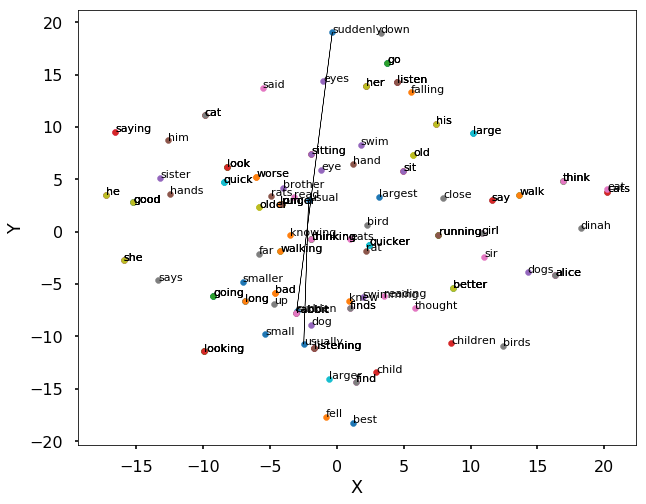

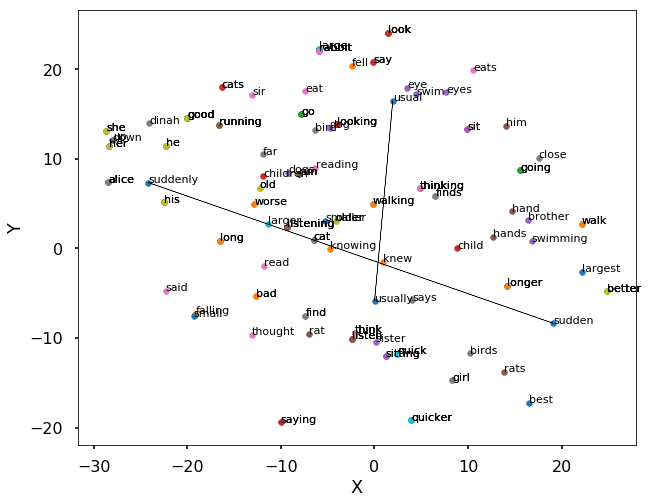

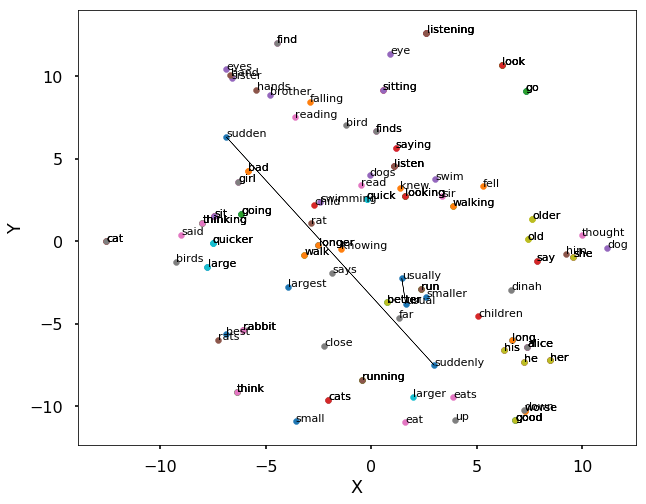

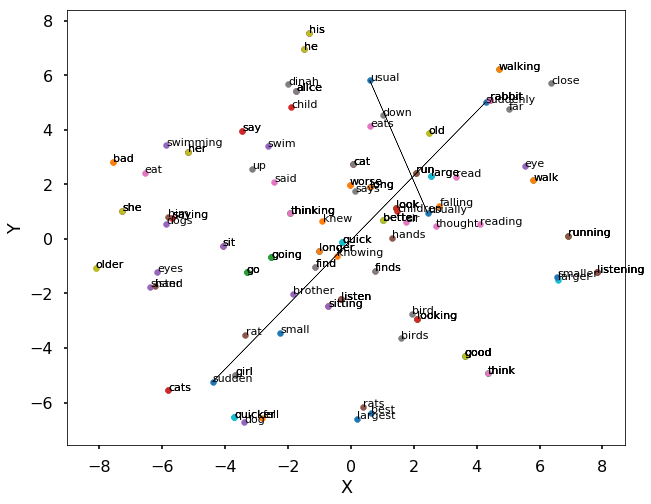

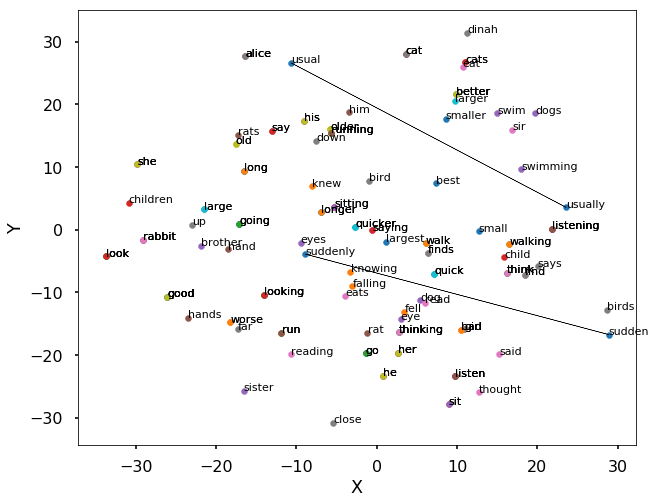

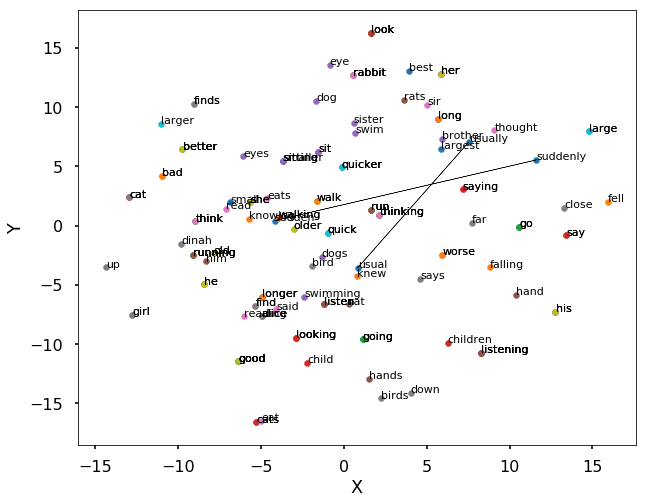

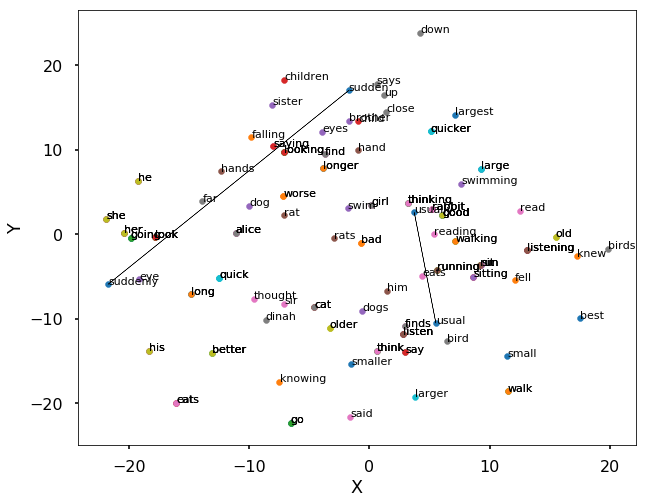

In [150]:
#Visualization results trained word embeddings
for f in embeddings_files:
    print('File:', f)
    model = KeyedVectors.load_word2vec_format(f + '.txt', binary=False)
    word_index = OrderedDict([(w, i) for i, w in enumerate(model.vocab)])
    vectors = [model[w] for w in word_index]
    vectors_2d = tsne.fit_transform(vectors)
    del vectors, model
    
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    first = True
    for sentence in generate_data_analogy_from_file():
        if not all(w in word_index for w in sentence):
            continue
        words = [w for w in sentence]
        word_idx = [word_index[w] for w in sentence]
        x = [vectors_2d[i][0] for i in word_idx]
        y = [vectors_2d[i][1] for i in word_idx]
        ax.scatter(x, y, s=35)
        for i, word in enumerate(words):
            ax.text(x[i] + 0.005, y[i] + 0.005, word, fontsize=11)
        
        # draw arrow between analogous words for a single analogy example
        if first:
            ax.arrow(*vectors_2d[word_idx[1]], *(vectors_2d[word_idx[0]]-vectors_2d[word_idx[1]]))
            ax.arrow(*vectors_2d[word_idx[3]], *(vectors_2d[word_idx[2]]-vectors_2d[word_idx[3]]))
            first = False
    
    fig.show()

Interpretation results:

The visualization and the performance results clearly indicates that none of the 12 models (Cbow, Skipgram, Cbow + 1, Skipgram + 1) * (3 embeddings vector lengths) produced good embeddings. The embeddings do not capture the analogous relationships given in the analogy_alice.txt file properly. The models at most get 2 of 38 analogies correct even with weak analogy checking condition. We believe this may be due to limited corpus training data, short window size = 2 and no proper tuning of the size of the network. The loss of the Cbow + 1 and Skipgram + 1 models is less relative to their corresponding models without the additional hidden layer. This indicates that the models are underfitting and can be improved further.

Compare the results of the trained word embeddings with the word-word co-occurrence matrix:

File: vector_co_occurrence
# of analogies correct: 1
% of analogies correct: 2.63%



C:\Users\XE89IW.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


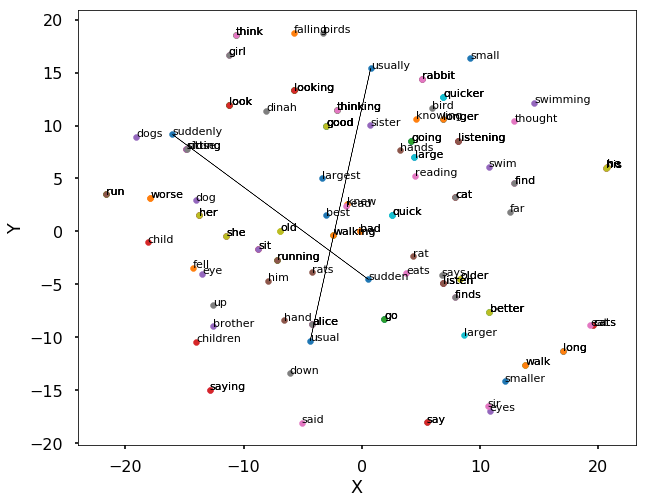

In [151]:
print('File: vector_co_occurrence')
n_analogies_correct = 0
word_index = OrderedDict([(w, i) for i, w in enumerate(co_occurrence.vocab)])
vectors = [co_occurrence[w] for w in word_index]
vectors_2d = tsne.fit_transform(vectors)
del vectors

fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.set_xlabel('X')
ax.set_ylabel('Y')

first = True
for sentence in generate_data_analogy_from_file():
    if not all(w in word_index for w in sentence):
        continue
    analogy_task = check_analogy(sentence, co_occurrence)
    n_analogies_correct += int(analogy_task)
    words = [w for w in sentence]
    word_idx = [word_index[w] for w in sentence]
    x = [vectors_2d[i][0] for i in word_idx]
    y = [vectors_2d[i][1] for i in word_idx]
    ax.scatter(x, y, s=35)
    for i, word in enumerate(words):
        ax.text(x[i] + 0.005, y[i] + 0.005, word, fontsize=11)

    # draw arrow between analogous words for a single analogy example
    if first:
        idx = [word_index[w] for w in sentence]
        ax.arrow(*vectors_2d[word_idx[1]], *(vectors_2d[word_idx[0]]-vectors_2d[word_idx[1]]))
        ax.arrow(*vectors_2d[word_idx[3]], *(vectors_2d[word_idx[2]]-vectors_2d[word_idx[3]]))
        first = False

print('# of analogies correct:', n_analogies_correct)
print('% of analogies correct: {:.2f}%\n'.format(n_analogies_correct / total_analogies * 100))
del word_index, vectors_2d, co_occurrence
fig.show()

We see from the following that the co-occurrence matrix embeddings only gets 1 of 38 analogies correct. Thus, almost equally bad results as the supposedly more sophisticated CBOW and Skipgram models. This was expected though since calculating co-occurrence similarity is deterministic and therefore usually inferior to models trained on context to predict a "target" word.

Discussion of the advantages of CBOW and Skipgram, the advantages of negative sampling and drawbacks of CBOW and Skipgram:

CBOW
* $+$ Once the learning has been done, the trained model can be stored and reused.
* $+$ It is superior to deterministic algorithms such as co-occurrence matrix.
* $-$ The model limited to content on which it was learned.
* $+$ CBOW is low in memory use and allows for quick predictions.
* $-$ Words in CBOW can only have one meaning. When a word is used within multiple contexts where it has a different meaning for the different contexts, the word gets placed in between the clusters for these contexts. Thus being badly predicted for its different meanings. 
* $-$ Rare words will almost never be predicted. Instead CBOW will provide more commen words for the given context.

Skipgram
* $+$ Once the learning has been done, the trained model can be stored and reused.
* $+$ Words can have multiple semantic meanings.
* $+$ Generally outperforms all other methods when combined with negative sampling in terms of performance and training time.
* $-$ The model limited to content on which it was learned.
* $-$ Skipgram combines the different contexts of words which are used in different contexts with different meanings
* $-$ Skipgram is able to predict the context for rare words, even though these predictions might be less accurate.

Negative sampling
* $+$ Negative sampling requires us to update only a fraction of the weights, this is a huge increase in learning performance.
* $+$ Negative sampling improves the overal quality of the predictions by on average making the change to the correct word more important when compared to the incorrect words.

In [7]:
#load pretrained word embeddings
embeddings = [("H:\Downloads\Compressed\GoogleNews-vectors-negative300.bin", True), 
              ("H:\Downloads\Compressed\glove.6B.300d_converted.txt", False)]

def load_embeddings(embeddings):
    for path, binary in embeddings:
        yield path, KeyedVectors.load_word2vec_format(path, binary=binary)

#convert GloVe into word2vec format
# gensim.scripts.glove2word2vec.get_glove_info(path)
# gensim.scripts.glove2word2vec.glove2word2vec(path, "glove.6B.300d_converted.txt")

In [12]:
# analogy_words = [w for sentence in generate_data_analogy_from_file() for w in sentence]

for path, model in load_embeddings(embeddings):
    print('File:', path)
    n_analogies_correct = 0
#     word_index = OrderedDict([(w, i) for i, w in enumerate(analogy_words) if w in model.vocab])
#     vectors = [model[w] for w in word_index]
#     vectors_2d = tsne.fit_transform(vectors)
#     del vectors

#     fig = plt.figure(figsize=(10, 8))
#     ax = plt.axes()
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')

#     first = True
    for sentence in generate_data_analogy_from_file():
        if not all(w in model.vocab for w in sentence):
            continue
        analogy_task = check_analogy(sentence, model)
        n_analogies_correct += int(analogy_task)
#         words = [w for w in sentence]
#         word_idx = [word_index[w] for w in sentence]
#         x = [vectors_2d[i][0] for i in word_idx]
#         y = [vectors_2d[i][1] for i in word_idx]
#         ax.scatter(x, y, s=35)
#         for i, word in enumerate(words):
#             ax.text(x[i] + 0.005, y[i] + 0.005, word, fontsize=11)

        # draw arrow between analogous words for a single analogy example
#         if first:
#             idx = [word_index[w] for w in sentence]
#             ax.arrow(*vectors_2d[word_idx[1]], *(vectors_2d[word_idx[0]]-vectors_2d[word_idx[1]]))
#             ax.arrow(*vectors_2d[word_idx[3]], *(vectors_2d[word_idx[2]]-vectors_2d[word_idx[3]]))
#             del idx
#             first = False

    print('# of analogies correct:', n_analogies_correct)
    print('% of analogies correct: {:.2f}%\n'.format(n_analogies_correct / total_analogies * 100))
#     fig.show()

File: H:\Downloads\Compressed\GoogleNews-vectors-negative300.bin
# of analogies correct: 36
% of analogies correct: 76.60%

File: H:\Downloads\Compressed\glove.6B.300d_converted.txt
# of analogies correct: 36
% of analogies correct: 76.60%



Comparison performance with your own trained word embeddings

The pre-trained embeddings get 36 out of 46 embeddings correct which is definitely an improvement over the cbow and skipgram models. Due to MemoryError, I could not obtain the visualization but the performance comparison is given.